In [18]:
import os
import pandas as pd
import numpy as np

def get_artifact_count(data_prefix, overlap_threshold):
    """
    Calculates the number of artifacts in the train/val/test set.

    If one artifact annotation for a specified overlap threshold is sufficient to label at least one window as `True`
    then that artifact annotation is counted.
    """
    artifact_count = 0
    for root, dir, files in os.walk(data_prefix):
        if os.path.basename(root) == 'unsorted':
            continue
        for file in files:
            if not file.endswith('.csv'):
                continue
            df = pd.read_csv(os.path.join(root, file), comment='#')
            for _, artifact_annot in df.iterrows():
                start_overlap = int((1 - artifact_annot['start_time'] % 1) > overlap_threshold)
                end_overlap = int((artifact_annot['stop_time'] % 1) > overlap_threshold)
                intermediate_windows = max(0, int(artifact_annot['stop_time']) - int(np.ceil(artifact_annot['start_time'])))
                if start_overlap + end_overlap + intermediate_windows >= 1:
                    artifact_count += 1
    return artifact_count

In [19]:
import sys
sys.path.append('../03 - Training')

import numpy as np
from utils.training import get_features_and_labels

thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
labels = [f'labels_{threshold}_treshold' for threshold in thresholds]
split_train = 'train'
split_val = 'val'
split_test = 'test'
feature_file = '../03 - Training/features/features.hdf5'
data_split_file = '../03 - Training/data_split.yaml'

total_set_proportion = []
artifact_counts = []

for label, threshold in zip(labels, thresholds):
    _, y_train = get_features_and_labels(feature_file, None, split_train, data_split_file, label_str=label)
    _, y_val = get_features_and_labels(feature_file, None, split_val, data_split_file, label_str=label)
    _, y_test = get_features_and_labels(feature_file, None, split_test, data_split_file, label_str=label)

    train_set_true_count = np.sum(y_train)
    train_set_total_count = len(y_train)
    val_set_true_count = np.sum(y_val)
    val_set_total_count = len(y_val)
    test_set_true_count = np.sum(y_test)
    test_set_total_count = len(y_test)

    # Pad labels with zeros to then count artifacts with diff
    padded_y_train = np.concatenate(([0], y_train, [0]))
    padded_y_val = np.concatenate(([0], y_val, [0]))
    padded_y_test = np.concatenate(([0], y_test, [0]))

    artifact_count = get_artifact_count('../../../../tuar_processed', threshold)

    artifact_counts.append(artifact_count)
    total_set_proportion.append((train_set_true_count + val_set_true_count + test_set_true_count) / (train_set_total_count + val_set_total_count + test_set_total_count))

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:02<00:00, 132.83it/s]


In [20]:
artifact_counts

[142917,
 142818,
 141504,
 139367,
 136530,
 132859,
 129061,
 122813,
 114418,
 104082,
 91185]

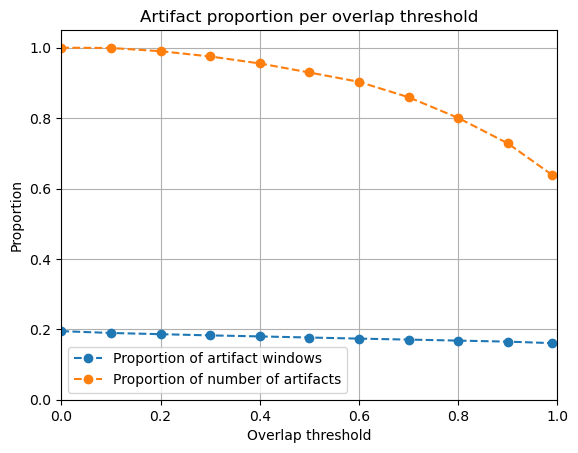

In [25]:
from matplotlib import pyplot as plt

overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
max_artifacts = artifact_counts[0]

plt.plot(overlaps, total_set_proportion, label='Proportion of artifact windows', marker='o', linestyle='--')
plt.plot(overlaps, np.array(artifact_counts) / max_artifacts, label='Proportion of number of artifacts', marker='o', linestyle='--')

plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True)
plt.xlabel('Overlap threshold')
plt.ylabel('Proportion')
plt.title('Artifact proportion per overlap threshold')
plt.legend()
plt.savefig('output/exp_04_05_proportion_artifacts.pdf', bbox_inches='tight')
plt.show()